<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import datetime as dt

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [253]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [254]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [255]:
# !git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

# data_dir_='Transfer-Learning-COVID-19/dataset_4_classes/'


In [256]:
# train_loader = torch.utils.data.DataLoader(
#              torch.utils.data.ConcatDataset([
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "train/"), transform=transform),
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "test/"), transform=transform)]
#              ),
#              batch_size=64,
#              num_workers=2, shuffle=True)

In [257]:
# print(len(train_loader.dataset))

In [258]:
img_dim=64
N_rot=3
N_flip=5
N_tran=7
N_scal=3
transform_list=[]

transform_list.append(transforms.Grayscale(num_output_channels=1))

transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

for i in range(N_rot):
  transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-2,2))], p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
# for i in range(N_flip):
#   transform_list.append(transforms.RandomVerticalFlip(p=0.5))
for i in range(N_scal):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
for i in range(N_tran):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

transform_list.append(transforms.ToTensor())

transform_list.append(transforms.Normalize((0.5), (0.5)))

transform_ = transforms.Compose(transform_list)

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [420]:
batch_size_train=64
batch_size_test=36
num_samples=batch_size_train*8
img_dim=64

data_dir = 'custom_covid_dataset/classic_augment/4_classes'
data_dir_gan = 'custom_covid_dataset/gan_augment/4_classes'

data_dir_new = 'custom_covid_dataset/classic_augment_2/4_classes'

# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# transform_resize = transforms.Compose([transforms.Resize((img_dim,img_dim)),
#                                 transforms.Grayscale(num_output_channels=1),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((0.5), (0.5))])

trainset0 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new, "0/"), transform=transform)
# trainset500 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir_new, "500/"), transform=transform)
# trainset1000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "1000/"), transform=transform)
# trainset2000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "2000/"), transform=transform)

trainset100_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "100/"), transform=transform)
trainset500_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "500/"), transform=transform)
trainset1000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "1000/"), transform=transform)
# trainset2000_gan = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir_gan, "2000/"), transform=transform)

# trainset0_ = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "0/"), transform=transform_)
# trainset1_ = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "0/"), transform=transform_)

listtrainset = [trainset0]
trainset_concat = torch.utils.data.ConcatDataset(listtrainset)

sampler = torch.utils.data.RandomSampler(trainset_concat,replacement=True, num_samples=num_samples)

trainloader = torch.utils.data.DataLoader(trainset_concat,  sampler=sampler, # shuffle=True, #
                                          batch_size=batch_size_train, drop_last=True)

testset0 = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)
# testset40 = torchvision.datasets.ImageFolder(os.path.join( 
#           'custom_covid_dataset/', "more_covid_samples/"), transform=transform_resize)
listtestset = [testset0]
testloader = torch.utils.data.DataLoader(
          torch.utils.data.ConcatDataset(listtestset), batch_size=batch_size_test, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac", "pneumonia_vir")

In [421]:
print(len(trainloader.dataset))

270


In [422]:
print(len(testloader.dataset))

36


In [423]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img_=np.transpose(npimg, (1, 2, 0))
    if img_.shape[2]==1:
      img_=img_[:,:,0]
    plt.imshow(img_)
    plt.show()


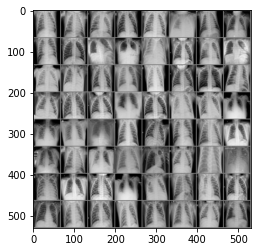

pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac normal covid covid pneumonia_bac normal pneumonia_bac covid pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_vir normal normal pneumonia_vir normal pneumonia_vir normal covid normal pneumonia_bac pneumonia_bac covid covid covid covid pneumonia_bac normal pneumonia_bac pneumonia_vir normal covid pneumonia_bac covid pneumonia_bac pneumonia_vir normal pneumonia_vir covid pneumonia_vir normal normal covid pneumonia_bac pneumonia_vir pneumonia_vir normal pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir normal pneumonia_bac


In [424]:
# get some random training images
dataiter = iter(trainloader)
images_train, labels_train = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_train))
# print labels
print(' '.join('%5s' % classes[labels_train[j]] for j in range(batch_size_train)))

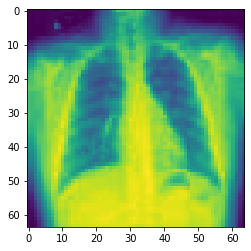

normal


In [425]:
rnd = np.random.randint(0,batch_size_train)
imshow(images_train[rnd])
print(classes[labels_train[rnd]])

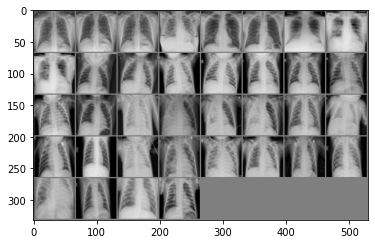

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [426]:
dataiter = iter(testloader)
images_test, labels_test = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(batch_size_test)))

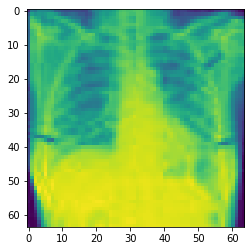

covid


In [427]:
rnd = np.random.randint(0,batch_size_test)
imshow(images_test[rnd])
print(classes[labels_test[rnd]])

In [428]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, class_number),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size, class_number):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size = channels_size
        self.class_number = class_number
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [429]:
hidden_size=32
channels_size=1
class_number=4

net=CNN(hidden_size, channels_size, class_number)

In [430]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [431]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

summary(net, (channels_size, img_dim, img_dim))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14            


Epoch: [1]  => Loss: [1.356]



Epoch: [2]  => Loss: [1.248]



Epoch: [3]  => Loss: [1.164]



Epoch: [4]  => Loss: [1.067]



Epoch: [5]  => Loss: [1.055]



Epoch: [6]  => Loss: [0.979]



Epoch: [7]  => Loss: [0.993]



Epoch: [8]  => Loss: [0.961]



Epoch: [9]  => Loss: [0.933]



Epoch: [10]  => Loss: [0.932]



Epoch: [10]  => Confusion Matrix Test: [1]  => Total Accuracy over 1800 samples: [0.649]


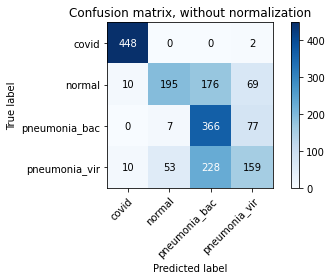

Epoch: [10]  => Evaluation Confusion Matrix Test: [1]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.988 │         0.996 │         0.985 │     0.992 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.825 │         0.433 │         0.956 │     0.562 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.729 │         0.813 │         0.701 │     0.767 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.756 │         0.353 │         0.89  │     0.474 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [11]  => Loss: [0.922]



Epoch: [12]  => Loss: [0.940]



Epoch: [13]  => Loss: [0.919]



Epoch: [14]  => Loss: [0.879]



Epoch: [15]  => Loss: [0.882]



Epoch: [16]  => Loss: [0.868]



Epoch: [17]  => Loss: [0.861]



Epoch: [18]  => Loss: [0.830]



Epoch: [19]  => Loss: [0.849]



Epoch: [20]  => Loss: [0.845]



Epoch: [20]  => Confusion Matrix Test: [2]  => Total Accuracy over 1800 samples: [0.709]


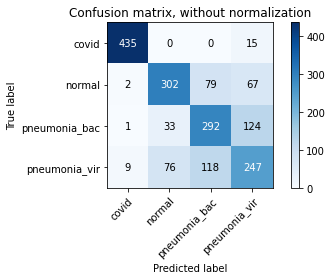

Epoch: [20]  => Evaluation Confusion Matrix Test: [2]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.985 │         0.967 │         0.991 │     0.975 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.857 │         0.671 │         0.919 │     0.75  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.803 │         0.649 │         0.854 │     0.715 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.773 │         0.549 │         0.847 │     0.637 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [21]  => Loss: [0.822]



Epoch: [22]  => Loss: [0.815]



Epoch: [23]  => Loss: [0.808]



Epoch: [24]  => Loss: [0.796]



Epoch: [25]  => Loss: [0.804]



Epoch: [26]  => Loss: [0.789]



Epoch: [27]  => Loss: [0.790]



Epoch: [28]  => Loss: [0.791]



Epoch: [29]  => Loss: [0.786]



Epoch: [30]  => Loss: [0.783]



Epoch: [30]  => Confusion Matrix Test: [3]  => Total Accuracy over 1800 samples: [0.713]


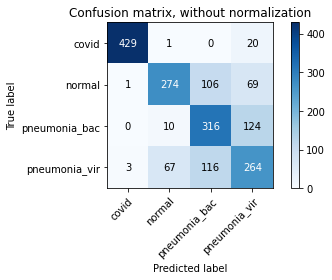

Epoch: [30]  => Evaluation Confusion Matrix Test: [3]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.986 │         0.953 │         0.997 │     0.969 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.859 │         0.609 │         0.942 │     0.71  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.802 │         0.702 │         0.836 │     0.747 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.778 │         0.587 │         0.842 │     0.666 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [31]  => Loss: [0.779]



Epoch: [32]  => Loss: [0.778]



Epoch: [33]  => Loss: [0.774]



Epoch: [34]  => Loss: [0.774]



Epoch: [35]  => Loss: [0.777]



Epoch: [36]  => Loss: [0.766]



Epoch: [37]  => Loss: [0.767]



Epoch: [38]  => Loss: [0.761]



Epoch: [39]  => Loss: [0.765]



Epoch: [40]  => Loss: [0.761]



Epoch: [40]  => Confusion Matrix Test: [4]  => Total Accuracy over 1800 samples: [0.726]


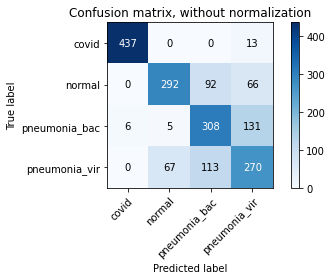

Epoch: [40]  => Evaluation Confusion Matrix Test: [4]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.989 │         0.971 │         0.996 │     0.98  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.872 │         0.649 │         0.947 │     0.742 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.807 │         0.684 │         0.848 │     0.737 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.783 │         0.6   │         0.844 │     0.677 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [41]  => Loss: [0.760]



Epoch: [42]  => Loss: [0.760]



Epoch: [43]  => Loss: [0.758]



Epoch: [44]  => Loss: [0.759]



Epoch: [45]  => Loss: [0.759]



Epoch: [46]  => Loss: [0.757]



Epoch: [47]  => Loss: [0.756]



Epoch: [48]  => Loss: [0.756]



Epoch: [49]  => Loss: [0.757]



Epoch: [50]  => Loss: [0.756]



Epoch: [50]  => Confusion Matrix Test: [5]  => Total Accuracy over 1800 samples: [0.732]


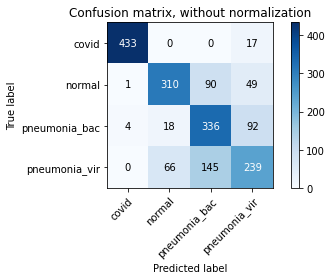

Epoch: [50]  => Evaluation Confusion Matrix Test: [5]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.988 │         0.962 │         0.996 │     0.974 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.876 │         0.689 │         0.938 │     0.769 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.806 │         0.747 │         0.826 │     0.773 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.795 │         0.531 │         0.883 │     0.634 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [51]  => Loss: [0.754]



Epoch: [52]  => Loss: [0.753]



Epoch: [53]  => Loss: [0.753]



Epoch: [54]  => Loss: [0.753]



Epoch: [55]  => Loss: [0.754]



Epoch: [56]  => Loss: [0.753]



Epoch: [57]  => Loss: [0.752]



Epoch: [58]  => Loss: [0.752]


In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    running_loss = 0.0
    if (epoch+1)%10==0:
        with torch.no_grad():
            accuracy_tot = list(0. for i in range(len(classes)))
            sensitivity_tot = list(0. for i in range(len(classes)))
            specificity_tot = list(0. for i in range(len(classes)))
            f1score_tot = list(0. for i in range(len(classes)))
            table = list(0. for i in range(len(classes)))
            tot_acc_tot=0

            iterations=50
            labels_tot=np.array([],dtype=np.uint8)
            predicted_tot=np.array([],dtype=np.uint8)

            for i in notebook.tqdm(range(iterations)):
              dataiter = iter(testloader)
              images, labels = dataiter.next()

              outputs = net(images.to(device))

              _, predicted = torch.max(outputs, 1)

              labels_tot=np.append(labels_tot,labels.cpu().detach().numpy())
              predicted_tot=np.append(predicted_tot,predicted.cpu().detach().numpy())

              cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

              tot_acc=np.trace(cm)/np.sum(cm)

              tot_acc_tot+=tot_acc

              sensitivity = list(0. for i in range(cm.shape[0]))
              specificity = list(0. for i in range(cm.shape[0]))
              accuracy = list(0. for i in range(cm.shape[0]))
              f1score = list(0. for i in range(cm.shape[0]))

              for i in range(cm.shape[0]):
                TP = cm[i,i]
                FN = np.sum(cm[i,:]) - TP
                FP = np.sum(cm[:,i]) - TP
                TN = (np.sum(cm) - TP - FP - FN)
                accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
                sensitivity[i] = TP / (TP + FN) 
                specificity[i] = TN / (TN + FP) 
                f1score[i]= 2 * (accuracy[i] * sensitivity[i]) / (accuracy[i] + sensitivity[i])
              accuracy_tot = [sum(x) for x in zip(accuracy_tot, accuracy)]
              specificity_tot = [sum(x) for x in zip(specificity_tot, specificity)]
              sensitivity_tot = [sum(x) for x in zip(sensitivity_tot, sensitivity)]
              f1score_tot = [sum(x) for x in zip(f1score_tot, f1score)]
              
            accuracy_tot = [round((x/iterations),3) for x in accuracy_tot]
            specificity_tot = [round((x/iterations),3) for x in specificity_tot]
            sensitivity_tot = [round((x/iterations),3) for x in sensitivity_tot]
            f1score_tot = [round((x/iterations),3) for x in f1score_tot]
            tot_acc_tot/=iterations
            running_loss/=(iterations*len(testloader))

            table=[classes, accuracy_tot, sensitivity_tot, specificity_tot, f1score_tot]
            table=np.array(table).T.tolist()

            plot_confusion_matrix(labels_tot, predicted_tot, classes=np.asarray(classes), normalize=False)
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy over %d samples: [%.3f]" %(len(testloader.dataset)*iterations, tot_acc_tot))

            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))

print('Finished Training')
PATH = './CNN_CLASSIC_'+str(channels_size)+'c_D'+str(len(listtrainset))+'_{}.pth'.format(dt.datetime.now())
torch.save(net.state_dict(), PATH)

In [384]:
# net.load_state_dict(torch.load(PATH))
# net.eval()

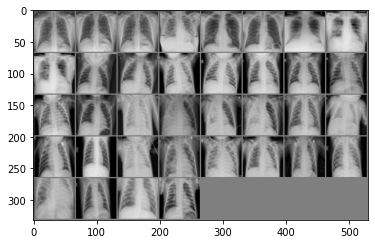

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir
Predicted:  covid covid covid covid covid covid covid covid covid pneumonia_vir normal pneumonia_bac normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir normal


In [417]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

In [418]:
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, target_names=classes, digits=3))

               precision    recall  f1-score   support

        covid      1.000     1.000     1.000         9
       normal      0.875     0.778     0.824         9
pneumonia_bac      0.692     1.000     0.818         9
pneumonia_vir      0.833     0.556     0.667         9

     accuracy                          0.833        36
    macro avg      0.850     0.833     0.827        36
 weighted avg      0.850     0.833     0.827        36




Total Accuracy over 18000 samples: [0.751]


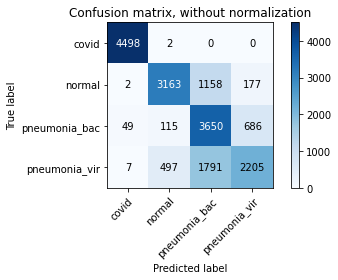

╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │      0.997 │         1     │         0.996 │     0.998 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │      0.892 │         0.703 │         0.955 │     0.784 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │      0.789 │         0.811 │         0.782 │     0.798 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │      0.825 │         0.49  │         0.936 │     0.612 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛


In [419]:
accuracy_tot = list(0. for i in range(cm.shape[0]))
sensitivity_tot = list(0. for i in range(cm.shape[0]))
specificity_tot = list(0. for i in range(cm.shape[0]))
f1score_tot = list(0. for i in range(cm.shape[0]))
table = list(0. for i in range(cm.shape[0]))
tot_acc_tot=0

iterations=500
labels_tot=np.array([],dtype=np.uint8)
predicted_tot=np.array([],dtype=np.uint8)

with torch.no_grad():
  for i in notebook.tqdm(range(iterations)):
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    outputs = net(images.to(device))

    _, predicted = torch.max(outputs, 1)

    labels_tot=np.append(labels_tot,labels.cpu().detach().numpy())
    predicted_tot=np.append(predicted_tot,predicted.cpu().detach().numpy())

    cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

    tot_acc=np.trace(cm)/np.sum(cm)

    tot_acc_tot+=tot_acc

    sensitivity = list(0. for i in range(cm.shape[0]))
    specificity = list(0. for i in range(cm.shape[0]))
    accuracy = list(0. for i in range(cm.shape[0]))
    f1score = list(0. for i in range(cm.shape[0]))

    for i in range(cm.shape[0]):
      TP = cm[i,i]
      FN = np.sum(cm[i,:]) - TP
      FP = np.sum(cm[:,i]) - TP
      TN = (np.sum(cm) - TP - FP - FN)
      accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
      sensitivity[i] = TP / (TP + FN) 
      specificity[i] = TN / (TN + FP) 
      f1score[i]= 2 * (accuracy[i] * sensitivity[i]) / (accuracy[i] + sensitivity[i])
    accuracy_tot = [sum(x) for x in zip(accuracy_tot, accuracy)]
    specificity_tot = [sum(x) for x in zip(specificity_tot, specificity)]
    sensitivity_tot = [sum(x) for x in zip(sensitivity_tot, sensitivity)]
    f1score_tot = [sum(x) for x in zip(f1score_tot, f1score)]
    
  accuracy_tot = [round((x/iterations),3) for x in accuracy_tot]
  specificity_tot = [round((x/iterations),3) for x in specificity_tot]
  sensitivity_tot = [round((x/iterations),3) for x in sensitivity_tot]
  f1score_tot = [round((x/iterations),3) for x in f1score_tot]
  tot_acc_tot/=iterations

  table=[classes, accuracy_tot, sensitivity_tot, specificity_tot, f1score_tot]

  table=np.array(table).T.tolist()

  plot_confusion_matrix(labels_tot, predicted_tot, classes=np.asarray(classes), normalize=False)

  print("Total Accuracy over %d samples: [%.3f]" %(len(testloader.dataset)*iterations, tot_acc_tot))

  plt.show()

  print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))


Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>
